# Predict Price with Weather data

Import Related Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

Load in and merge weather data

In [2]:
# Load in Weather and IGS data
igs_data = pd.read_csv("updated_igs_data.csv", index_col = 0)
hourly_weather = pd.read_csv("houston_hourly_weather_data.csv")

# Merge Data
hourly_weather["datetime"] = pd.to_datetime(hourly_weather["datetime"])
igs_data["LOCAL_FROM_DATETIME"] = pd.to_datetime(igs_data["LOCAL_FROM_DATETIME"])
price_df = igs_data.merge(hourly_weather, how = "left", left_on = "LOCAL_FROM_DATETIME", right_on = "datetime")

Clean Merged Data

In [3]:
# Rename and Add Columns
price_df.rename(columns = {"Delivery Date":"DateTime"}, inplace = True)
price_df["Month_Int"] = price_df["LOCAL_FROM_DATETIME"].apply(lambda d: d.month)

#Replace 'Settlement Point Price' with the actual column name from your CSV if it's different.
price_df['Settlement_Point_Price'] = pd.to_numeric(price_df['Settlement Point Price'], errors='coerce')
price_df['QUANTITY'] = pd.to_numeric(price_df['QUANTITY'], errors='coerce')

# Set 'DateTime' as the index
price_df.set_index('DateTime', inplace=True)

# Sort the DataFrame by DateTime to ensure it is in chronological order
price_df.sort_index(inplace=True)

price_df = price_df[price_df["ACCOUNT_NUMBER"] == "account_a"]

# Prices are the same for each account, so we can take prices from a single account

In [4]:
 #, #, "Hour", "Holiday", "Day", "Weekend", "temp"]]
important_vars = ["Settlement_Point_Price", "Month_Int", "temp", "Hour"]

# Days of the month greater than or equal to 25
val_data = price_df[price_df["Day"] >= 25]
val_data = val_data[important_vars].astype(float)
val_data = val_data.dropna()

# Days of the month between 3 and 25 exclusively
train_data = price_df[(price_df["Day"] > 3) & (price_df["Day"] < 25)]
train_data = train_data[important_vars].astype(float)
train_data = train_data.dropna()

Function to create sequences of data

In [5]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    # Create Rolling Windows
    for i in range(len(data) - seq_length):
        xs.append(data.iloc[i:(i + seq_length)])
        ys.append(data.iloc[i + seq_length])

    # Torch Arrays
    xs = torch.tensor(np.array(xs), dtype=torch.float32)
    ys = torch.tensor(np.array(ys), dtype=torch.float32)
    
    # Only need price for Y
    ys = ys[:,:1]
    
    return xs, ys

Our LSTM Model Architecture:

In [6]:
# Create Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CustomLSTM(nn.Module):
    def __init__(self, lstm_input_size, hidden_size, num_layers, output_size, aux_input_size = None, aux_hidden_size = None):
        super(CustomLSTM, self).__init__()

        # LSTM Layer
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(lstm_input_size, hidden_size, num_layers, batch_first=True)
        
        # Linear layer code:
        #self.aux_lin = torch.nn.Linear(aux_input_size, aux_hidden_size)

        ## Join Layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x_time):

        h_0 = torch.zeros(self.num_layers, x_time.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x_time.size(0), self.hidden_size).to(device)

        # LSTM Output
        out, _ = self.lstm(x_time, (h_0, c_0))

        # Transform into output
        out = self.fc(out[:, -1, :])

        return out

Dataset Initialization

In [7]:
# Create Sequences to look at past three days of data. (Arbitrary selection)
seq_length = 4

# Train Test Splits
X_train, Y_train = create_sequences(train_data, seq_length)
X_test, Y_test = create_sequences(val_data, seq_length)

# We throw out the first three days of every month because they would capture 
# information about the validation data, and we don't want this, so we remove them

Model Initalization:

In [8]:
# Hyperparameters
input_size = X_train.shape[-1]  # Number of lstm input features
hidden_size = 30  # Number of features in hidden state
num_layers = 1  # Number of stacked LSTM layers
output_size = 1  # Number of output values
num_epochs = 20000
learning_rate = 0.01

# Initialize Model
model = CustomLSTM(input_size, hidden_size, num_layers, output_size)
model = model.to(device)

# Set up loss and optimizer
criterion = torch.nn.MSELoss(reduction = "mean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

This is the training loop

In [9]:
train_loss_log = []
val_loss_log = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    output = model(X_train.to(device))
    loss = criterion(output.view(-1), Y_train.to(device).view(-1))
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    train_loss_log.append(loss.item() / len(X_train))

    # Validation Loss:
    model.eval()
    with torch.no_grad():
        Y_Test_pred = model(X_test.to(device))
        val_loss = criterion(Y_Test_pred.view(-1), Y_test.to(device).view(-1))
        val_loss_log.append(val_loss.item() / len(X_test))
        
    if (epoch+1) % 1000 == 0:
        train_loss_norm = loss.item() / len(X_train)
        val_loss_norm = val_loss.item() / len(X_test)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss_norm}, Val Loss: {val_loss_norm}')

  5%|▌         | 1041/20000 [00:03<01:07, 281.42it/s]

Epoch 1000, Train Loss: 5.5716314682044885, Val Loss: 48.313216004609544


 10%|█         | 2042/20000 [00:07<01:00, 298.60it/s]

Epoch 2000, Train Loss: 4.693353530236908, Val Loss: 43.01492170553146


 15%|█▌        | 3047/20000 [00:10<00:54, 313.22it/s]

Epoch 3000, Train Loss: 4.058352491167914, Val Loss: 39.70178196176789


 20%|██        | 4047/20000 [00:13<00:49, 323.85it/s]

Epoch 4000, Train Loss: 3.3710982959268496, Val Loss: 35.42549739018438


 25%|██▌       | 5040/20000 [00:16<00:46, 324.23it/s]

Epoch 5000, Train Loss: 2.928326969035744, Val Loss: 32.59003863882863


 30%|███       | 6041/20000 [00:19<00:42, 330.48it/s]

Epoch 6000, Train Loss: 2.7907600789692437, Val Loss: 34.1890548739154


 35%|███▌      | 7071/20000 [00:23<00:38, 336.62it/s]

Epoch 7000, Train Loss: 2.8389579436824603, Val Loss: 31.266874830531453


 40%|████      | 8059/20000 [00:25<00:33, 353.38it/s]

Epoch 8000, Train Loss: 2.4165259052888612, Val Loss: 30.413751101545554


 45%|████▌     | 9035/20000 [00:28<00:30, 355.39it/s]

Epoch 9000, Train Loss: 2.5828965996467166, Val Loss: 30.644327887744033


 50%|█████     | 10049/20000 [00:31<00:27, 356.19it/s]

Epoch 10000, Train Loss: 2.301335366012053, Val Loss: 30.007651504880695


 55%|█████▌    | 11061/20000 [00:34<00:25, 356.59it/s]

Epoch 11000, Train Loss: 2.1386426511845387, Val Loss: 30.38319592258677


 60%|██████    | 12063/20000 [00:37<00:22, 351.73it/s]

Epoch 12000, Train Loss: 2.1184442864193684, Val Loss: 29.69911918722885


 65%|██████▌   | 13064/20000 [00:40<00:19, 350.75it/s]

Epoch 13000, Train Loss: 2.559314928823774, Val Loss: 26.82380355206074


 70%|███████   | 14066/20000 [00:43<00:17, 340.20it/s]

Epoch 14000, Train Loss: 1.9621351893703243, Val Loss: 27.19197608798807


 75%|███████▌  | 15036/20000 [00:45<00:14, 352.63it/s]

Epoch 15000, Train Loss: 2.0806129208229427, Val Loss: 27.415433076870933


 80%|████████  | 16058/20000 [00:48<00:11, 357.44it/s]

Epoch 16000, Train Loss: 1.93913880662926, Val Loss: 26.887394505829718


 85%|████████▌ | 17078/20000 [00:51<00:08, 358.13it/s]

Epoch 17000, Train Loss: 1.9967061512884456, Val Loss: 26.33954506168655


 90%|█████████ | 18062/20000 [00:54<00:05, 352.79it/s]

Epoch 18000, Train Loss: 1.8548138118246051, Val Loss: 27.05621907199024


 95%|█████████▌| 19070/20000 [00:57<00:02, 353.09it/s]

Epoch 19000, Train Loss: 2.4052112557148795, Val Loss: 28.139430246746205


100%|██████████| 20000/20000 [01:00<00:00, 332.66it/s]

Epoch 20000, Train Loss: 2.3655462580527846, Val Loss: 27.443363611713664


Plot the Learning Curves

Text(0.5, 1.0, 'Price LSTM Training Curves')

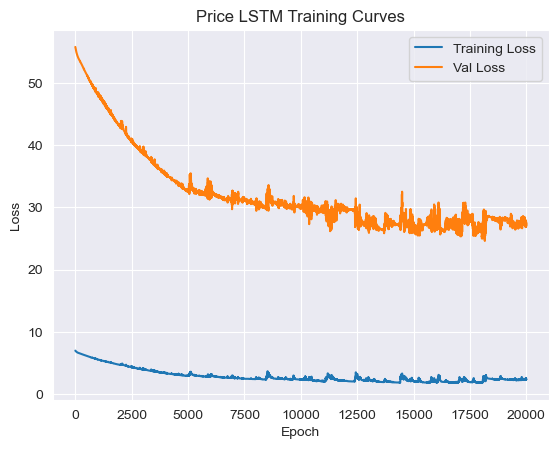

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_loss_log, label = "Training Loss")
plt.plot(val_loss_log, label = "Val Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Price LSTM Training Curves")

Plot Predictions

Test RMSE: 224.956801408626


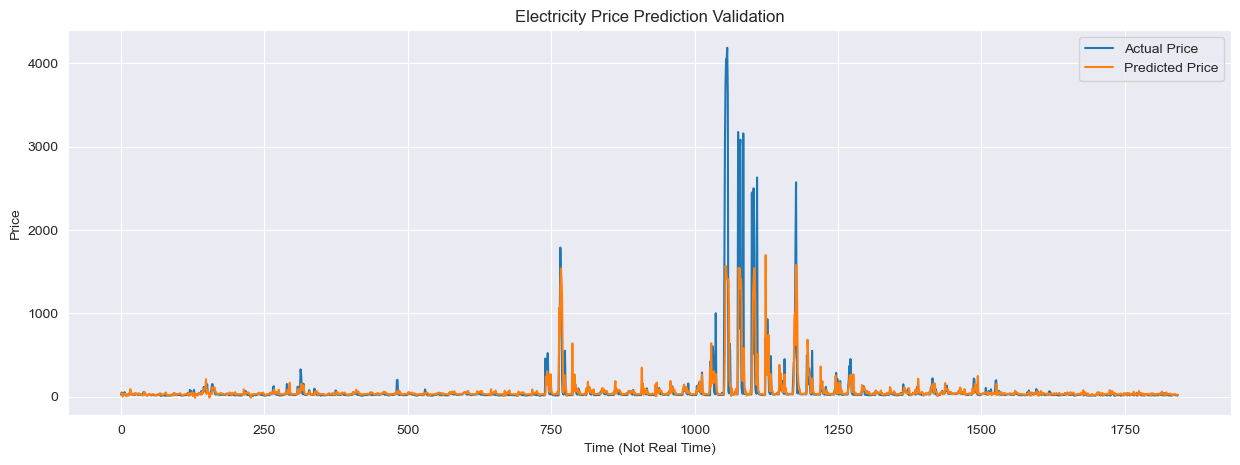

In [11]:
model.eval()
with torch.no_grad():
    Y_test_pred = model(X_test.to(device))
    
# y_test_pred = y_test_pred.cpu().numpy()
# y_test = y_test.to.numpy()

# Calculate RMSE
rmse = np.sqrt(criterion(Y_test.to(device), Y_test_pred).item())
print(f'Test RMSE: {rmse}')

plt.figure(figsize=(15, 5))
plt.plot(Y_test.cpu(), label='Actual Price')
plt.plot(Y_test_pred.cpu(), label='Predicted Price')
plt.title('Electricity Price Prediction Validation')
plt.xlabel('Time (Not Real Time)')
plt.ylabel('Price')
plt.legend()
plt.show()

In [12]:
np.sqrt((criterion(Y_test.to(device)[:1000], Y_test_pred[:1000]).item() + criterion(Y_test.to(device)[1250:], Y_test_pred[1250:]).item()) / 2) 

47.990284890253115

Potential future assessments:

1. Plot fitted values when using the feature vector in LSTM

In [13]:
import pandas as pd

# Create a pandas DataFrame including the datetime, actual prices, and predicted prices
df_predictions_with_date = pd.DataFrame({
    'datetime': val_data.index[seq_length:],
    'actual_price': Y_test.cpu().numpy().flatten(),
    'predicted_price': Y_test_pred.cpu().numpy().flatten()
})

# Now, save this DataFrame to a CSV file
csv_file_path = 'price_predictions_with_datetime_weather.csv'  # Specify your desired file path and name
df_predictions_with_date.to_csv(csv_file_path, index=False)  # Save the DataFrame without the index

print(f"Predictions with datetime saved to {csv_file_path}")

Predictions with datetime saved to price_predictions_with_datetime_weather.csv
